In [3]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


In [4]:
salary = pd.read_csv('WAG_C_M.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)

In [5]:
salary.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


In [6]:
salary.rename(columns={"WAG_C_M": "wage"}, inplace = True, )

In [7]:
salary.head()

,wage
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


<Figure size 1080x504 with 0 Axes>

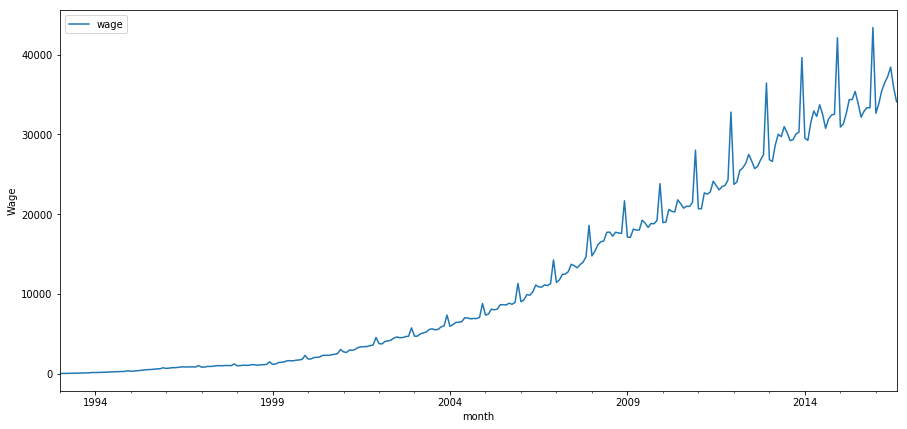

In [8]:
plt.figure(figsize(15,7))
salary.plot()
plt.ylabel('Wage')
pylab.show()

Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.991850


<Figure size 1080x720 with 0 Axes>

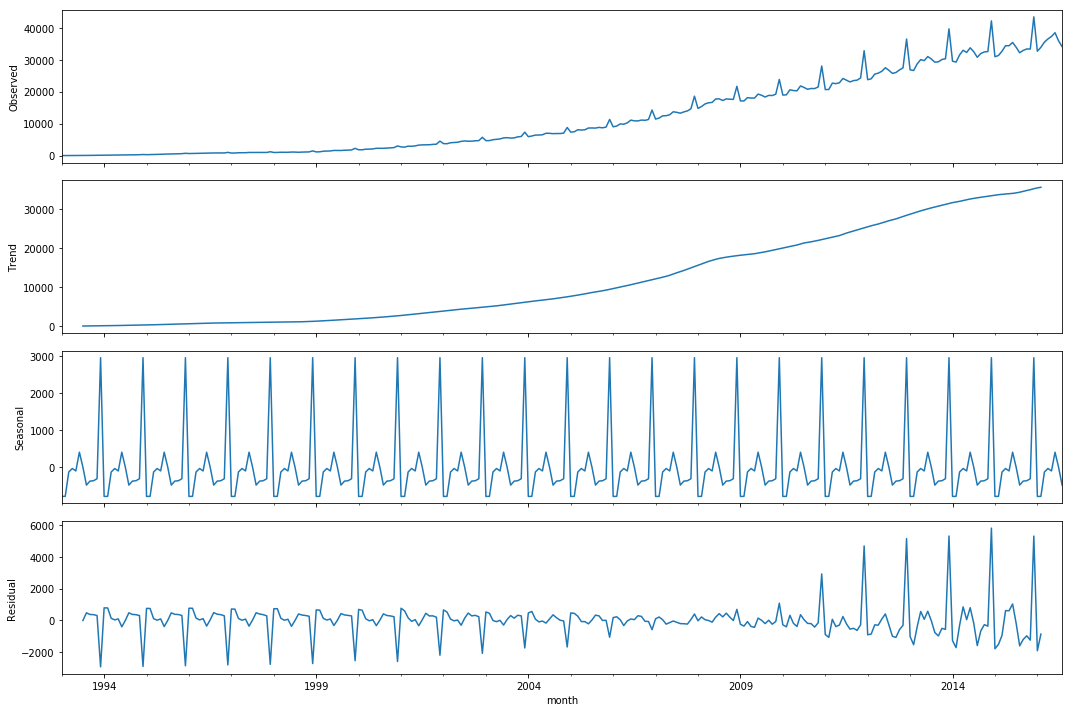

In [9]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.wage)[1])

Явно выраженные тренд и сезонность, увеличивающаяся дисперсия. Ряд нестационарный.

### Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


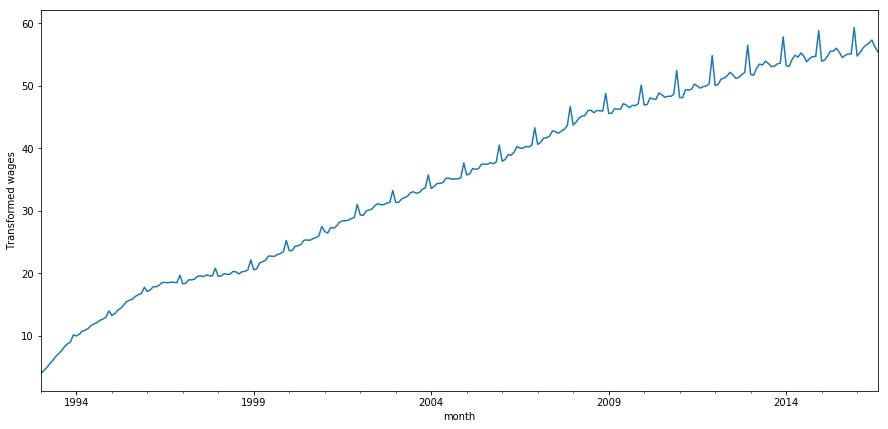

In [10]:
salary['wages_box'], lmbda = stats.boxcox(salary.wage)
plt.figure(figsize(15,7))
salary.wages_box.plot()
plt.ylabel(u'Transformed wages')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.wages_box)[1])

### Стационарность

Произведем сезонное дифференцирование

Критерий Дики-Фуллера: p=0.014697


<Figure size 1080x720 with 0 Axes>

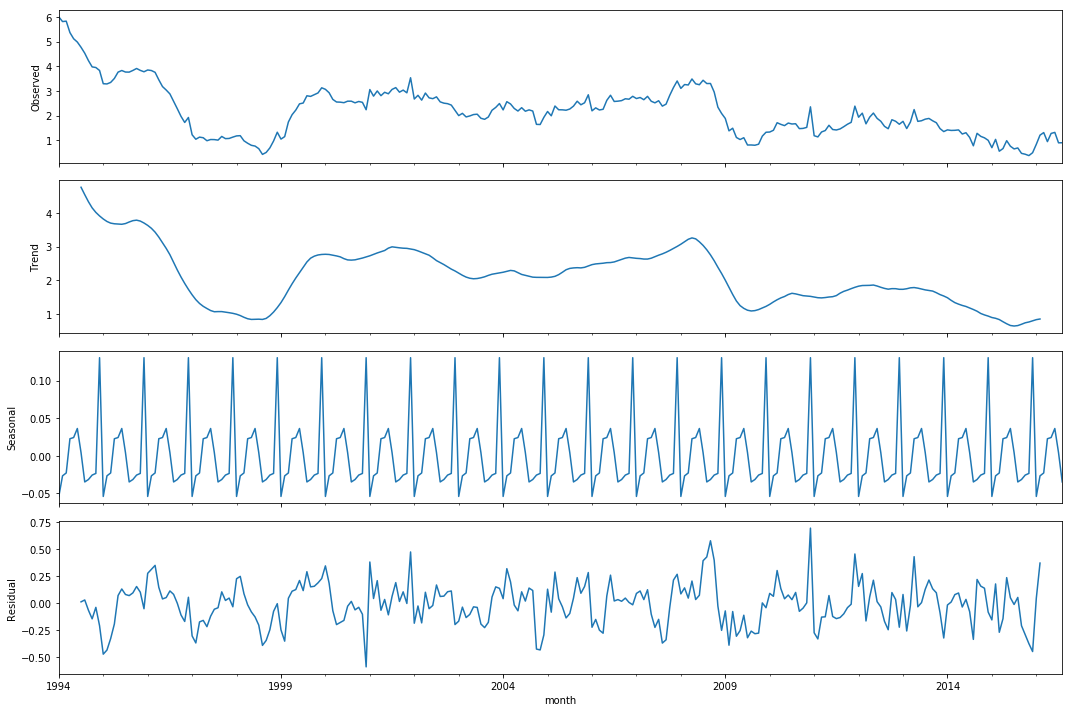

In [11]:
salary['wages_box_diff'] = salary.wages_box - salary.wages_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.wages_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.wages_box_diff[12:])[1])

Критерий Дики-Фуллера отвергает гипотезу нестационарности с p-value < 0.05. Попробуем применить еще  стационарное дифференцирование, чтобы улучшить результаты. 

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

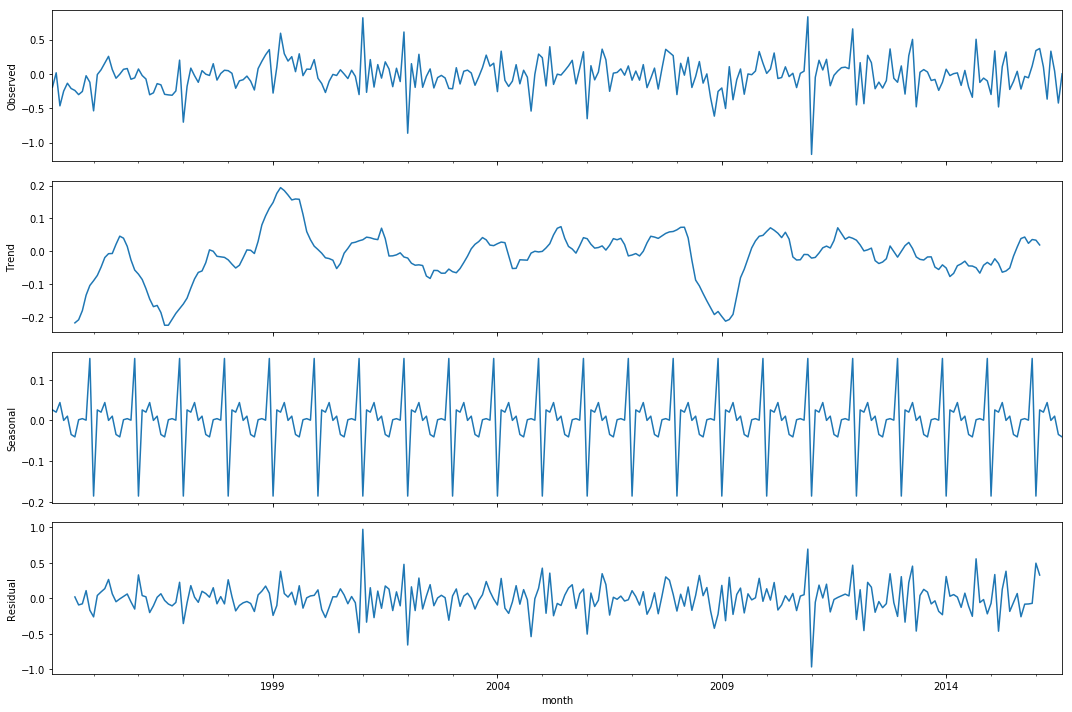

In [12]:
salary['wages_box_diff2'] = salary.wages_box_diff - salary.wages_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.wages_box_diff2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.wages_box_diff2[13:])[1])

Тренд полностью ушел. Гипотеза о нестационарности уверенно отвергается.

### Подбор модели

Посмотрим на ACF и PACF полученного ряда:

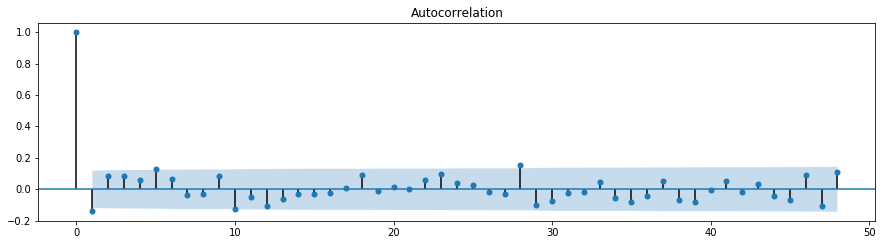

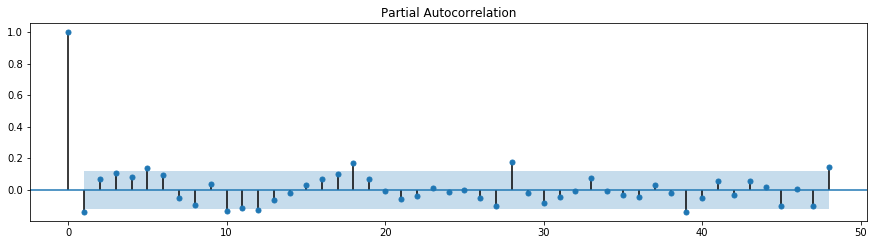

In [13]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(salary.wages_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(salary.wages_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

##### Начальные приближения: Q=0, q=5, P=1, p=11

In [14]:
ps = range(0, 11)
d=1
qs = range(0, 5)
Ps = range(0, 2)
D=1
Qs = [0,0]

In [15]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

220

In [16]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(salary.wages_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

('wrong parameters:', (1, 2, 0, 0))
('wrong parameters:', (1, 2, 0, 0))
('wrong parameters:', (1, 2, 1, 0))
('wrong parameters:', (1, 2, 1, 0))
('wrong parameters:', (2, 1, 0, 0))
('wrong parameters:', (2, 1, 0, 0))
('wrong parameters:', (2, 1, 1, 0))
('wrong parameters:', (2, 1, 1, 0))
('wrong parameters:', (2, 2, 0, 0))
('wrong parameters:', (2, 2, 0, 0))
('wrong parameters:', (2, 2, 1, 0))
('wrong parameters:', (2, 2, 1, 0))
('wrong parameters:', (3, 2, 0, 0))
('wrong parameters:', (3, 2, 0, 0))
('wrong parameters:', (3, 2, 1, 0))
('wrong parameters:', (3, 2, 1, 0))
('wrong parameters:', (4, 2, 0, 0))
('wrong parameters:', (4, 2, 0, 0))
('wrong parameters:', (4, 2, 1, 0))
('wrong parameters:', (4, 2, 1, 0))
('wrong parameters:', (4, 4, 0, 0))
('wrong parameters:', (4, 4, 0, 0))
('wrong parameters:', (4, 4, 1, 0))
('wrong parameters:', (4, 4, 1, 0))
('wrong parameters:', (5, 2, 0, 0))
('wrong parameters:', (5, 2, 0, 0))
('wrong parameters:', (5, 2, 1, 0))
('wrong parameters:', (5, 2,

In [17]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters        aic
40  (2, 3, 0, 0) -21.091493
41  (2, 3, 0, 0) -21.091493
43  (2, 3, 1, 0) -20.398611
42  (2, 3, 1, 0) -20.398611
44  (2, 4, 0, 0) -19.586560


In [18]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                          wages_box   No. Observations:                  284
Model:             SARIMAX(2, 1, 3)x(0, 1, 0, 12)   Log Likelihood                  16.546
Date:                            Thu, 02 May 2019   AIC                            -21.091
Time:                                    16:19:06   BIC                              0.521
Sample:                                01-01-1993   HQIC                           -12.414
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7529      0.073     23.990      0.000       1.610       1.896
ar.L2         -0.8662      0.067   

Ее остатки: 

Критерий Стьюдента: p=0.230247
Критерий Дики-Фуллера: p=0.000000


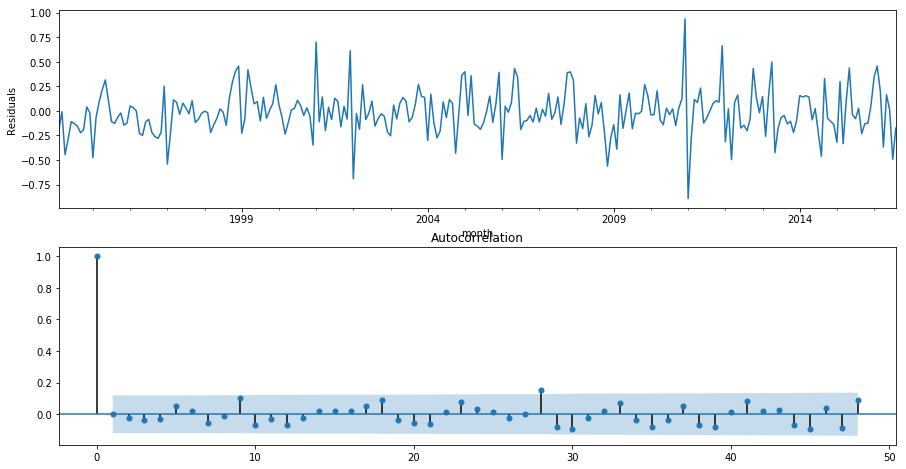

In [19]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Не видно тренда и сезонности, остатки похожи на шум. Некоторые лаги значимо отличаются от 0.

Cудя по  тому, что p-value критерию Дики-Фуллера  < 0.05, а  Стьюдента и Льюнга-Бокса > 0.05,  остатки несмещены, стационарны и неавтокореллированы.

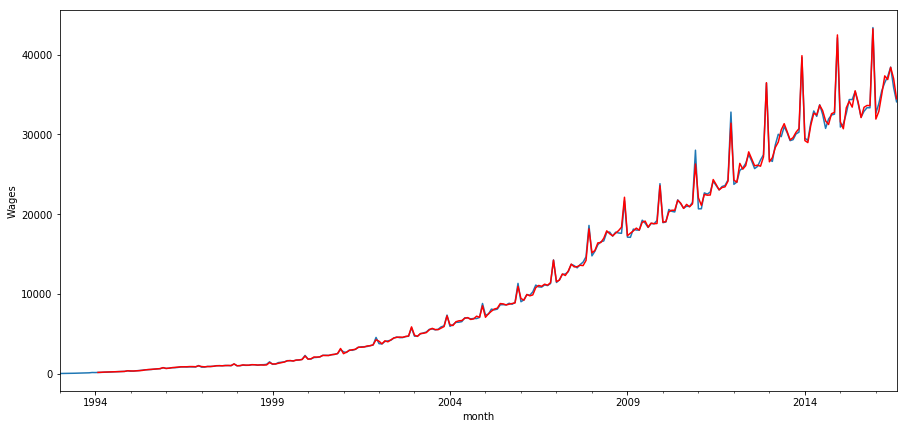

In [20]:
salary['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
salary.wage.plot()
salary.model[13:].plot(color='r')
plt.ylabel('Wages')
pylab.show()

Модель и данные достаточно похожи друг на друга.

### Прогноз

In [21]:
df1 = pd.DataFrame([['01.09.2016',35843.0],['01.10.2016',35749.0],['01.11.2016',36195.0],['01.12.2016',47554.0],['01.01.2017',34422.0],['01.02.2017',35497.0],['01.03.2017',37899.0],['01.04.2017',39225.0],['01.05.2017',39679.0],['01.06.2017',41454.0],['01.07.2017',38073.0],['01.08.2017',37099.0],['01.09.2017',38047.0],['01.10.2017',38333.0],['01.11.2017',38848.0],['01.12.2017',51197.0],['01.01.2018',39017.0],['01.02.2018',40443.0],['01.03.2018',42364.0],['01.04.2018',43381.0],['01.05.2018',44076.0],['01.06.2018',45848.0],['01.07.2018',42413.0],['01.08.2018',41364.0],['01.09.2018',41774.0],['01.10.2018',42000.0], ['01.09.2018',41774.0],['01.10.2018',42332.0],['01.11.2018',42595.0],['01.12.2018',55569.0]], columns = ('month', 'wage'))
df1 = pd.DataFrame(df1.wage.values, index = pd.to_datetime(df1.month, dayfirst = True), columns = ['wage'])

/Users/andreyleonov/anaconda2/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


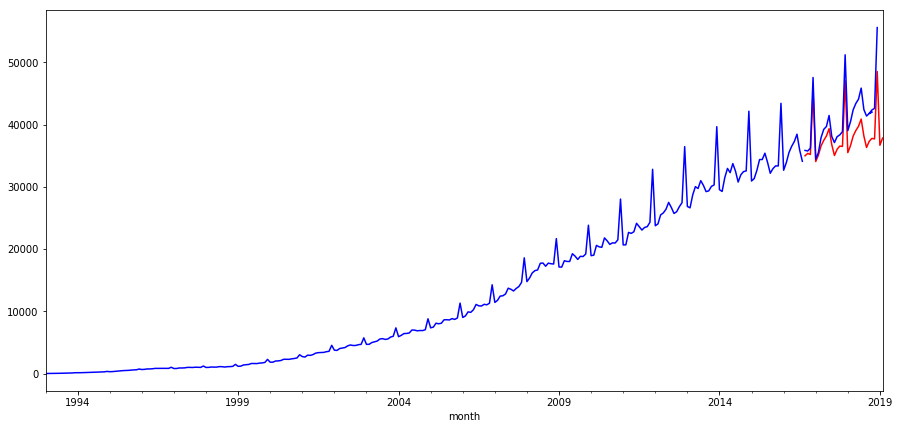

In [22]:
salary2 = salary[['wage']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,30)]
future = pd.DataFrame(index=date_list, columns= salary2.columns)
salary2 = pd.concat([salary2, future])
salary2['forecast'] = invboxcox(best_model.predict(start=284, end=319), lmbda)

plt.figure(figsize(15,7))
salary2.wage.plot(color='b')
salary2.forecast.plot(color='r')
df1.wage.plot(color = 'b')
#plt.ylabel('Wages')
pylab.show()